In [2]:
### --- Importing the Libraries
import pickle 
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from tensorflow.data import Dataset, TFRecordDataset
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU, Conv2D , Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K


In [3]:
### --- Loading the Dataset
with open('time_series_1.pickle', 'rb') as handle:
    time_series_1 = pickle.load(handle)
with open('time_series_2.pickle', 'rb') as handle:
    time_series_2 = pickle.load(handle)
with open('y.pickle', 'rb') as handle:
    y = pickle.load(handle)

In [ ]:
### --- printing the shapes of the data
print(time_series_1.shape)
print(time_series_2.shape)
print(y.shape)


(4000, 5000)
(4000, 5000)
(4000,)


In [ ]:
### --- Combining the two time series vertically with np.dstack 
combined = np.dstack((time_series_1, time_series_2))

In [ ]:
### --- printing the shape of the combined time series
combined.shape

(4000, 5000, 2)

In [ ]:
### --- Reshaping the y 
y1 = y.reshape(4000, 1)
y1

array([[1.],
       [2.],
       [3.],
       ...,
       [3.],
       [3.],
       [1.]])

In [ ]:
y.shape

(4000,)

In [ ]:
### --- Splitting into train-validation and test set
np.random.seed(132)
seq_steps = 5000

X_train, y_train = combined[:2800, :seq_steps], y1[:2800,]
X_valid, y_valid = combined[2800:3400, :seq_steps], y1[2800:3400,]
X_test, y_test = combined[3400:, :seq_steps], y1[3400:,]

### --- Printing the sets
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)                                               

(2800, 5000, 2)
(2800, 1)
(600, 5000, 2)


# Question 1
*Create a reccurent neural network in TensorFlow to predict the operating mode of a wind turbine base on two time series from the sensors. Before any implementation, carefully consider what type of approach (sequence-to-vector, sequence-to-sequence, or encoder-decoder) is most sensible here and how you need to manipulate the data, given that you have two different time series for each observation.*


*Then, make sure that you try out the different layers and elements discussed in class, such as SimpleRNN, LSTM and Conv1D - while a certain amount of trial and error will be necessary, it is recommended that you tune your network systematically. Make sure to record your final validation set accuracy.*

In [ ]:
### --- Creating a pre-defined function for training and plotting the model, so that we have to do less repetitions when creating all sorts of different models.
def train_plot(model, learning_rate = 0.001, epochs = 30):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),metrics=['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_valid)
    
    return model, log

**For all the models below, simple RNN, LSTM, GRU and Conv1D, activation softmax has been used in the output layer, because the problem has multi class classification(0,1,2,3).** 

## A simple RNN 

Trying out a simple RNN: one layer with 50 units and an output layer.

In [ ]:
### --- Trying a Simple RNN with 50 units and output equal to 4 
model_simple_RNN = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=[None, 2]),
    Dense(4, activation = "softmax")
])

model_simple_RNN.summary()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2650      
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 2,854
Trainable params: 2,854
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
88/88 [==============================] - 83s 935ms/step - loss: 1.3682 - accuracy: 0.2989 - val_loss: 1.3515 - val_accuracy: 0.3267
Epoch 2/30
88/88 [==============================] - 98s 1s/step - loss: 1.3163 - accuracy: 0.3518 - val_loss: 1.3243 - val_accuracy: 0.3700
Epoch 3/30
88/88 [==============================] - 102s 1s/step - loss: 1.2923 - accuracy: 0.3896 - val_loss: 1.2861 - val_accuracy: 0.3900
Epoch 4/30
88/88 [==============================] - 99s 1s/step - loss: 1.2665 - accuracy: 0.4114 - val_loss: 1.2594 - val_accuracy: 0.4150
Epoch 5/30
88/88 [==============================] - 94s 1s/step - loss: 1.2348 - accuracy: 0.4350 - val_loss: 1.2252 - val_accuracy: 0.4500
Epoch 6/30
88/88 [==============================] - 86s 984ms/step - loss: 1.2104 - accuracy: 0.4529 - val_loss: 1.2108 - val_accuracy: 0.4383
Epoch 7/30
88/88 [==============================] - 77s 874ms/step - loss: 1.1905 - accuracy: 0.4529 - val_loss: 1.1749 - val_accuracy: 0.4850
Epoch 8/30

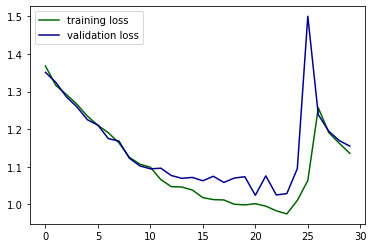

(<keras.engine.sequential.Sequential at 0x7f91560dc790>,
 <keras.callbacks.History at 0x7f9151e90910>)

In [ ]:
### --- Training and plotting the Simple RNN model
train_plot(model_simple_RNN)

In [ ]:
### --- Evaluating the Simple RNN model
score, acc = model_simple_RNN.evaluate(X_valid, y_valid)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 3s 163ms/step - loss: 1.1551 - accuracy: 0.4717
Validation score: 1.155062198638916
Validation accuracy: 0.4716666638851166


## Using LSTMs

Creating a LSTM model with multiple layers, so we need to set return_sequences = True so that all outputs are passed to the next layer, otherwise only the last outpout is passed to the next layer.




In [ ]:
## --- Creating a LSTM model with 3 layers and a Dense leyer with 10 output and activation softmax
model_LSTM = Sequential([
    LSTM(20, return_sequences= True , input_shape=[None, 2]), # --- Setting return sequences = True, because there is a following 
    LSTM(20 , return_sequences= True),                         # LSTM layer and all outputs need to be passed to the next layer
    LSTM(20),
    Dense(10, activation ='softmax')
])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1840      
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          3280      
                                                                 
 lstm_2 (LSTM)               (None, 20)                3280      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 8,610
Trainable params: 8,610
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
88/88 [==============================] - 726s 8s/step - loss: 1.6269 - accuracy: 0.2479 - val_loss: 1.4259 - val_accuracy: 0.2550
Epoch 2/30
88/88 [==============================] - 719s 8s/step - loss: 1.4099 - accuracy: 0.2504 - val_loss: 1.4033 - val_accuracy: 0.2550
Epoch 3/30
88/88 [==============================] - 724s 8s/step - loss: 1.3991 - accuracy: 0.2546 - val_loss: 1.3934 - val_accuracy: 0.2550
Epoch 4/30
88/88 [==============================] - 723s 8s/step - loss: 1.3928 - accuracy: 0.2736 - val_loss: 1.3904 - val_accuracy: 0.2867
Epoch 5/30
88/88 [==============================] - 724s 8s/step - loss: 1.3876 - accuracy: 0.2789 - val_loss: 1.3853 - val_accuracy: 0.2933
Epoch 6/30
88/88 [==============================] - 723s 8s/step - loss: 1.3789 - accuracy: 0.2932 - val_loss: 1.3760 - val_accuracy: 0.3433
Epoch 7/30
88/88 [==============================] - 723s 8s/step - loss: 1.3682 - accuracy: 0.3332 - val_loss: 1.3687 - val_accuracy: 0.2983
Epoch 8/30
88

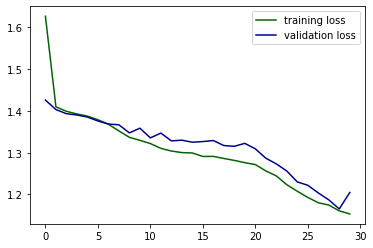

(<keras.engine.sequential.Sequential at 0x7f91516dd850>,
 <keras.callbacks.History at 0x7f915156d210>)

In [ ]:
### --- training and plotting the LSTM model
train_plot(model_LSTM)

In [ ]:
### --- Evaluating the LSTM  model
score, acc = model_LSTM.evaluate(X_valid, y_valid)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 14s 729ms/step - loss: 1.2047 - accuracy: 0.4317
Validation score: 1.204695463180542
Validation accuracy: 0.43166667222976685


## Using GRUs

Creating a GRUs model with multiple layers, so we need to set return_sequences = True so that all outputs are passed to the next layer, otherwise only the last output is passed to the next layer and the output is set to 4.

In [ ]:
### --- Creating a GRUs model
model_GRUs = Sequential([
    GRU(20, return_sequences=True, input_shape=[None, 2]),
    GRU(20),
    Dense(4,activation ='softmax')
])
model_GRUs.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1440      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense_2 (Dense)             (None, 4)                 84        
                                                                 
Total params: 4,044
Trainable params: 4,044
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
88/88 [==============================] - 422s 5s/step - loss: 1.3752 - accuracy: 0.2982 - val_loss: 1.3325 - val_accuracy: 0.3850
Epoch 2/30
88/88 [==============================] - 416s 5s/step - loss: 1.2741 - accuracy: 0.4336 - val_loss: 1.2397 - val_accuracy: 0.4833
Epoch 3/30
88/88 [==============================] - 415s 5s/step - loss: 1.2063 - accuracy: 0.5025 - val_loss: 1.1584 - val_accuracy: 0.4967
Epoch 4/30
88/88 [==============================] - 417s 5s/step - loss: 1.1540 - accuracy: 0.5175 - val_loss: 1.1119 - val_accuracy: 0.5417
Epoch 5/30
88/88 [==============================] - 419s 5s/step - loss: 1.1120 - accuracy: 0.5454 - val_loss: 1.0911 - val_accuracy: 0.5750
Epoch 6/30
88/88 [==============================] - 417s 5s/step - loss: 1.0846 - accuracy: 0.5579 - val_loss: 1.0802 - val_accuracy: 0.5483
Epoch 7/30
88/88 [==============================] - 417s 5s/step - loss: 1.0575 - accuracy: 0.5686 - val_loss: 1.0346 - val_accuracy: 0.5683
Epoch 8/30
88

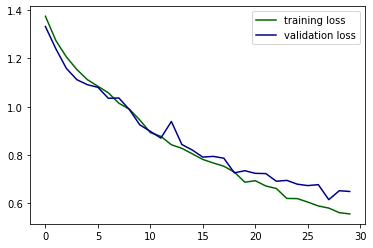

(<keras.engine.sequential.Sequential at 0x7f914fef9ed0>,
 <keras.callbacks.History at 0x7f914feabf10>)

In [ ]:
### --- Training and plotting the GRUs model
train_plot(model_GRUs)

In [ ]:
### --- Evalauting the GRU model
score, acc = model_GRUs.evaluate(X_valid, y_valid)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 8s 423ms/step - loss: 0.6479 - accuracy: 0.7317
Validation score: 0.6479480862617493
Validation accuracy: 0.7316666841506958


## Using Conv1D

Creating and training One-dimensional convolutional with two GRU layers and an output layer of 4.


In [ ]:
### --- Creating the Conv1D model
model_Conv1D = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=4, padding="valid",input_shape=[None, 2]),
    GRU(20, return_sequences=True),
    GRU(40),
    Dense(4, activation='softmax')
])
model_Conv1D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 gru_2 (GRU)                 (None, None, 20)          2520      
                                                                 
 gru_3 (GRU)                 (None, 40)                7440      
                                                                 
 dense_3 (Dense)             (None, 4)                 164       
                                                                 
Total params: 10,304
Trainable params: 10,304
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
88/88 [==============================] - 92s 1s/step - loss: 1.2810 - accuracy: 0.4032 - val_loss: 1.1438 - val_accuracy: 0.4833
Epoch 2/30
88/88 [==============================] - 88s 998ms/step - loss: 1.0609 - accuracy: 0.5264 - val_loss: 0.9847 - val_accuracy: 0.5400
Epoch 3/30
88/88 [==============================] - 88s 998ms/step - loss: 0.9334 - accuracy: 0.5943 - val_loss: 0.9184 - val_accuracy: 0.5850
Epoch 4/30
88/88 [==============================] - 88s 999ms/step - loss: 0.8738 - accuracy: 0.6189 - val_loss: 0.8408 - val_accuracy: 0.6350
Epoch 5/30
88/88 [==============================] - 88s 1s/step - loss: 0.7881 - accuracy: 0.6661 - val_loss: 0.7944 - val_accuracy: 0.6583
Epoch 6/30
88/88 [==============================] - 88s 1000ms/step - loss: 0.7167 - accuracy: 0.7025 - val_loss: 0.7465 - val_accuracy: 0.6850
Epoch 7/30
88/88 [==============================] - 88s 1s/step - loss: 0.6829 - accuracy: 0.7289 - val_loss: 0.6857 - val_accuracy: 0.7100
Epoch 8

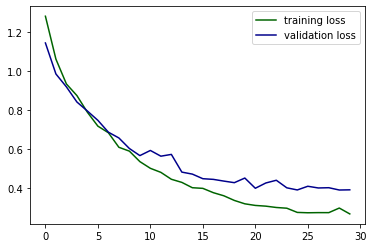

(<keras.engine.sequential.Sequential at 0x7f9150ad67d0>,
 <keras.callbacks.History at 0x7f9150a862d0>)

In [ ]:
### --- training and plotting the Conv1D model 
train_plot(model_Conv1D)

In [ ]:
### --- Evaluating the Conv1D model.
score, acc = model_Conv1D.evaluate(X_valid, y_valid)

print('Validation loss:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 3s 135ms/step - loss: 0.3898 - accuracy: 0.8567
Validation score: 0.3898051083087921
Validation accuracy: 0.8566666841506958


## Deep RNN: sequence-to-vector


In [ ]:
### --- Creating a Deep RNN model with two layers.
model_Deep_RNN = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 2]),
    SimpleRNN(20),
    Dense(10, activation='softmax')
])
model_Deep_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          460       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,490
Trainable params: 1,490
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
88/88 [==============================] - 389s 4s/step - loss: 1.7842 - accuracy: 0.2300 - val_loss: 1.4882 - val_accuracy: 0.2733
Epoch 2/30
88/88 [==============================] - 381s 4s/step - loss: 1.4334 - accuracy: 0.3054 - val_loss: 1.4107 - val_accuracy: 0.3233
Epoch 3/30
88/88 [==============================] - 381s 4s/step - loss: 1.3707 - accuracy: 0.3318 - val_loss: 1.3682 - val_accuracy: 0.3517
Epoch 4/30
88/88 [==============================] - 380s 4s/step - loss: 1.3344 - accuracy: 0.3707 - val_loss: 1.3446 - val_accuracy: 0.3817
Epoch 5/30
88/88 [==============================] - 380s 4s/step - loss: 1.3143 - accuracy: 0.3932 - val_loss: 1.3287 - val_accuracy: 0.4000
Epoch 6/30
88/88 [==============================] - 380s 4s/step - loss: 1.2978 - accuracy: 0.4057 - val_loss: 1.3147 - val_accuracy: 0.3933
Epoch 7/30
88/88 [==============================] - 380s 4s/step - loss: 1.2847 - accuracy: 0.4182 - val_loss: 1.2883 - val_accuracy: 0.4167
Epoch 8/30
88

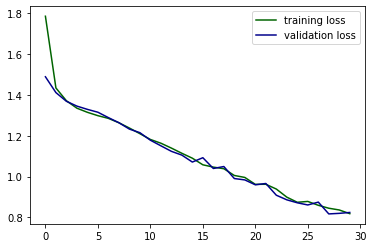

(<keras.engine.sequential.Sequential at 0x7fa9c6161810>,
 <keras.callbacks.History at 0x7fa9c58e3d10>)

In [ ]:
### --- Training and plotting the Deep RNN model.
train_plot(model_Deep_RNN)

In [ ]:
### --- Evaluating the Deep RNN model.
score, acc = model_Deep_RNN.evaluate(X_valid, y_valid)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 7s 360ms/step - loss: 0.8245 - accuracy: 0.6683
Validation score: 0.8244910836219788
Validation accuracy: 0.6683333516120911


# Question 2
*In your own words, explain why the approach outlined here can help analyze time-series
data and why it might outperform RNNs.*


> The approach outlined in the article is the transformation of time series into images in order to used as a CNN model and predict the turbine's status, healthy, if the generator torque is faulty, if the pitch angle is faulty, and if both are faulty.

> CNNs use convolution operations that can handle spatial information available in images. In addition to this CNN are highly noise resistant models, and for that reason are able to extract very informative, deep features, that are independent from time.

> CNN model might outperform RNN model because:

* CNNs are computationally "cheaper" than RNNs. CNN models learn by batch while RNNs train sequentially. As a result, RNN can’t use parallelization because it must wait for the previous computations.
* CNNs don’t have the assumption that history is complete.CNNs learn patterns within the time window, and not like RNN. If there are any  missing data, CNNs should be more useful.
* RNN models only learn from data before the timestep it needs to predict.On the other hand, CNNs can see data from a broader perspective. CNNs are "feed-forward neural networks" that use filters and pooling layers, while RNNs feed results back into the network.










# Question 3
*Convert the data for use with a CNN. In particular, following the approach outlined in
Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time
series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a grayscale image).*


In [4]:
### --- combining the two time series, horizontally  for the CNN model as shown in Figure 18.
combined_cnn = np.hstack((time_series_1, time_series_2))
combined_cnn

array([[30, 29, 29, ...,  2,  2,  1],
       [31, 31, 30, ...,  1,  1,  1],
       [28, 28, 28, ...,  0,  0,  0],
       ...,
       [28, 28, 28, ...,  0,  0,  0],
       [28, 28, 29, ...,  1,  0,  0],
       [31, 31, 30, ...,  0,  0,  0]], dtype=uint8)

In [5]:
### --- printing the shape of the new combined array
combined_cnn.shape

(4000, 10000)

In [ ]:
y3 = y 

In [ ]:
### --- splitting into train-validation and test set 
np.random.seed(132)
seq_steps = 10000

X_train_q3, y_train_q3 = combined_cnn[:2800, :seq_steps], y3[:2800,]
X_valid_q3, y_valid_q3 = combined_cnn[2800:3400, :seq_steps], y3[2800:3400,]
X_test_q3, y_test_q3 = combined_cnn[3400:, :seq_steps], y3[3400:,]

print('x_train shape:', X_train_q3.shape)
print('x_test shape:', X_test_q3.shape)
print('y_train shape:', y_train_q3.shape)
print('y_test shape:', y_test_q3.shape)

x_train shape: (2800, 10000)
x_test shape: (600, 10000)
y_train shape: (2800,)
y_test shape: (600,)


In [ ]:
### --- Transforming the data for use as an image with dimensions (100,100,1)

num_classes = len(np.unique(y3)) ## -- number of classes in the data
img_rows, img_cols, img_channels = 100, 100, 1 ## -- input image dimensions (100,100,1)

### --- Loading and converting data from uint8 to float32
X_train_q3 = X_train_q3.astype('float32')
X_test_q3 = X_test_q3.astype('float32')
X_valid_q3 = X_valid_q3.astype('float32')


### --- Converting class vectors to one-hot encoding
y_train_q3 = tf.keras.utils.to_categorical(y_train_q3, num_classes)
y_test_q3 = tf.keras.utils.to_categorical(y_test_q3, num_classes)
y_valid_q3 = tf.keras.utils.to_categorical(y_valid_q3, num_classes)


### --- Depending on the implementation, the underlying libraries might want the image 
# dimensions in different orders, so we create an if.
if K.image_data_format() == 'channels_first':
    X_train_q3 = X_train_q3.reshape(X_train_q3.shape[0], img_channels, img_rows, img_cols)
    X_test_q3 = X_test_q3.reshape(X_test_q3.shape[0], img_channels, img_rows, img_cols)
    X_valid_q3 = X_valid_q3.reshape(X_valid_q3.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train_q3 = X_train_q3.reshape(X_train_q3.shape[0], img_rows, img_cols, img_channels)
    X_test_q3 = X_test_q3.reshape(X_test_q3.shape[0], img_rows, img_cols, img_channels)
    X_valid_q3 = X_valid_q3.reshape(X_valid_q3.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)



In [ ]:
### --- Printing the shapes 

print('X_train shape:', X_train_q3.shape)
print('y_train shape:', y_train_q3.shape)
print('X_valid shape:', X_valid_q3.shape)
print('y_valid shape:', y_valid_q3.shape)



X_train shape: (2800, 100, 100, 1)
y_train shape: (2800, 4)
X_valid shape: (600, 100, 100, 1)
y_valid shape: (600, 4)


# Question 4
*In TensorFlow, replicate the CNN with three convolutional layers displayed in Figure 12
and train it on your data. Make sure to record your final validation set accuracy.*

In [ ]:
### --- Creating the CNN model of the figure 12, with:
# 3 Conv2D layers, one dropout layer, one max pooling layer, a flatten layer and a Dense layer.

model_CNN = Sequential([
    Conv2D(32, kernel_size=(3, 3),input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3)), 
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),activation='relu'),  
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 96, 96, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 94, 94, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 15376)             0         
                                                      

In [ ]:
### --- fitting the CNN model 
CNN = model_CNN.fit(X_train_q3, y_train_q3,  epochs = 15, validation_data=(X_valid_q3, y_valid_q3)) 

Epoch 1/15
88/88 [==============================] - 117s 1s/step - loss: 22.2287 - accuracy: 0.2882 - val_loss: 1.3861 - val_accuracy: 0.2617
Epoch 2/15
88/88 [==============================] - 100s 1s/step - loss: 1.3593 - accuracy: 0.3321 - val_loss: 1.3650 - val_accuracy: 0.3533
Epoch 3/15
88/88 [==============================] - 103s 1s/step - loss: 1.0471 - accuracy: 0.5518 - val_loss: 0.6520 - val_accuracy: 0.7683
Epoch 4/15
88/88 [==============================] - 115s 1s/step - loss: 0.4342 - accuracy: 0.8446 - val_loss: 0.2844 - val_accuracy: 0.9067
Epoch 5/15
88/88 [==============================] - 98s 1s/step - loss: 0.3255 - accuracy: 0.8679 - val_loss: 0.2749 - val_accuracy: 0.8950
Epoch 6/15
88/88 [==============================] - 100s 1s/step - loss: 0.3012 - accuracy: 0.8750 - val_loss: 0.2521 - val_accuracy: 0.9033
Epoch 7/15
88/88 [==============================] - 99s 1s/step - loss: 0.2678 - accuracy: 0.8811 - val_loss: 0.2462 - val_accuracy: 0.9033
Epoch 8/15
88/

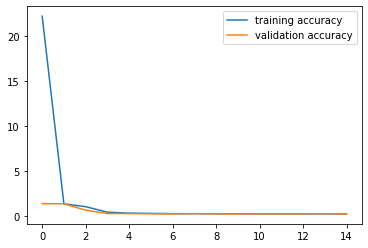

In [ ]:
### --- plotting the training accuracy and validation accuracy.
plt.plot(CNN.history['loss'], label = 'training accuracy')
plt.plot(CNN.history['val_loss'], label = 'validation accuracy')
plt.legend()
plt.show()

In [ ]:
### --- Evaluating the CNN model

score, acc = model_CNN.evaluate(X_valid_q3, y_valid_q3)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 4s 216ms/step - loss: 0.2472 - accuracy: 0.9000
Validation score: 0.24722658097743988
Validation accuracy: 0.8999999761581421


# Question 5
*Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy.*

Trying to improve the CNN model by adding:



* one more Max pooling layer after the first Conv2D layer, in order to calculate the maximum value for each patch. The addition of a pooling layer after the convolutional layer is a common pattern used for ordering layers within a convolutional neural network that may be repeated one or more times in a given model.

*  a reduction of the units in the second Conv2D layer from 32 to 16.

* a Dropout layer equal to 0.4 in order to prevent overfitting.

* an extra Conv2D layer with 32 units

* and an extra Dropout layer equal to 0.4.










In [ ]:
### ---  Creating the new CNN model
model_CNN_2 = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=1,input_shape=input_shape),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(16, kernel_size=(3, 3),strides=2,input_shape=input_shape), 
    Dropout(0.4),
    Conv2D(32, kernel_size=(3, 3),strides=2),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),strides=1,activation='relu'),  
    Dropout(0.4),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_CNN_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_CNN_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 16)        4624      
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 32)          0         
                                                      

In [ ]:
### --- Training the model
CNN_2 = model_CNN_2.fit(X_train_q3, y_train_q3, batch_size= 30, epochs = 20, validation_data=(X_valid_q3, y_valid_q3)) 

Epoch 1/20
94/94 [==============================] - 15s 150ms/step - loss: 8.8125 - accuracy: 0.3704 - val_loss: 1.3409 - val_accuracy: 0.6067
Epoch 2/20
94/94 [==============================] - 14s 148ms/step - loss: 3.0319 - accuracy: 0.5129 - val_loss: 0.4174 - val_accuracy: 0.8917
Epoch 3/20
94/94 [==============================] - 14s 147ms/step - loss: 1.9756 - accuracy: 0.6093 - val_loss: 0.2805 - val_accuracy: 0.9033
Epoch 4/20
94/94 [==============================] - 14s 147ms/step - loss: 1.2836 - accuracy: 0.6707 - val_loss: 0.2634 - val_accuracy: 0.9083
Epoch 5/20
94/94 [==============================] - 14s 147ms/step - loss: 0.9643 - accuracy: 0.7332 - val_loss: 0.2461 - val_accuracy: 0.9067
Epoch 6/20
94/94 [==============================] - 14s 147ms/step - loss: 0.7923 - accuracy: 0.7621 - val_loss: 0.2504 - val_accuracy: 0.9033
Epoch 7/20
94/94 [==============================] - 14s 147ms/step - loss: 0.6901 - accuracy: 0.7796 - val_loss: 0.2404 - val_accuracy: 0.9000

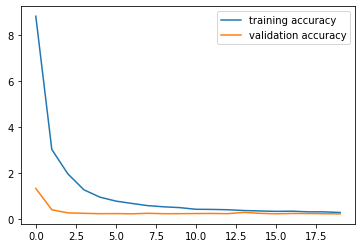

In [ ]:
### --- Plotting the model CNN_2
plt.plot(CNN_2.history['loss'], label = 'training accuracy')
plt.plot(CNN_2.history['val_loss'], label = 'validation accuracy')
plt.legend()
plt.show()

In [ ]:
### --- Evaluating the CNN_2 model

score, acc = model_CNN_2.evaluate(X_valid_q3, y_valid_q3)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 1s 48ms/step - loss: 0.2361 - accuracy: 0.9067
Validation score: 0.23612205684185028
Validation accuracy: 0.9066666960716248


 **---The next step is to use functions for the model AlexNet, Xception and GoogleNet in order to achieve higher accuracy for the CNN model.**

## ---- AlexNet

In [ ]:
### --- Importing libraries

from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.models import Model
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization



In [ ]:
### --- Creating an AlexNet function in order to improve the model

def alexnet(input_shape = (100,100,1), n_classes = 4):
  input = Input(input_shape)
  
  x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(256, 5, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)
  
  x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = Flatten()(x)
  x = Dense(4096, activation='softmax')(x)
  x = Dense(4096, activation='softmax')(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model_alexnet = Model(input, output)

  return model_alexnet

In [ ]:
### --- summary and compiling the model

input_shape = 100, 100, 1
n_classes = 4

K.clear_session()
model_alexnet = alexnet(input_shape, n_classes)
model_alexnet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_alexnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 256)      1024  

In [ ]:
### --- Training the alexnet model

model_Alexnet = model_alexnet.fit(X_train_q3, y_train_q3, epochs = 15, validation_data=(X_valid_q3, y_valid_q3))

Epoch 1/15
88/88 [==============================] - 104s 1s/step - loss: 1.3864 - accuracy: 0.2468 - val_loss: 1.3862 - val_accuracy: 0.2350
Epoch 2/15
88/88 [==============================] - 103s 1s/step - loss: 1.3851 - accuracy: 0.3129 - val_loss: 1.3840 - val_accuracy: 0.2350
Epoch 3/15
88/88 [==============================] - 103s 1s/step - loss: 1.3810 - accuracy: 0.3239 - val_loss: 1.3789 - val_accuracy: 0.4750
Epoch 4/15
88/88 [==============================] - 102s 1s/step - loss: 1.3644 - accuracy: 0.6171 - val_loss: 1.3650 - val_accuracy: 0.4167
Epoch 5/15
88/88 [==============================] - 102s 1s/step - loss: 1.3263 - accuracy: 0.5211 - val_loss: 1.3471 - val_accuracy: 0.3717
Epoch 6/15
88/88 [==============================] - 102s 1s/step - loss: 1.2714 - accuracy: 0.4843 - val_loss: 1.3981 - val_accuracy: 0.2550
Epoch 7/15
88/88 [==============================] - 102s 1s/step - loss: 1.2063 - accuracy: 0.4786 - val_loss: 1.4181 - val_accuracy: 0.2550
Epoch 8/15
88

In [ ]:
### --- Evaluating the alexnet model

score, acc = model_alexnet.evaluate(X_valid_q3, y_valid_q3)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 4s 226ms/step - loss: 0.8318 - accuracy: 0.4883
Validation score: 0.8317584991455078
Validation accuracy: 0.4883333444595337


## ---- Xception

In [ ]:
### --- Creating a function for the xception 

def xception(input_shape, n_classes):
  
  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, 50, 3)
    x = ReLU()(x)
    x = sep_bn(x, 50, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 50, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 60, 3)
    x = ReLU()(x)
    x = sep_bn(x, 60, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 60, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 70, 3)
    x = ReLU()(x)
    x = sep_bn(x, 70, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 70, 1, 2)
    x = Add()([tensor, x])
    
    return x

  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 70, 3)
      x = ReLU()(x)
      x = sep_bn(x, 70, 3)
      x = ReLU()(x)
      x = sep_bn(x, 70, 3)

      tensor = Add()([tensor, x])
    
    return tensor
  
  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 70, 3)
    x = ReLU()(x)
    x = sep_bn(x, 80, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 80, 1, 2)
    
    x = Add()([tensor, x])
    x = sep_bn(x, 90, 3)
    x = ReLU()(x)
    x = sep_bn(x, 100, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)
  
    return x

  input = Input(input_shape)
  
  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)
  
  model_xception = Model(input, output)
  
  return model_xception

In [ ]:
### --- summary and compiling the xception model

input_shape = 100, 100, 1
n_classes = 4

K.clear_session()
model_xception = xception(input_shape, n_classes)
model_xception.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
### --- Training the xception model 

model_Xception = model_xception.fit(X_train_q3, y_train_q3, epochs = 15, validation_data=(X_valid_q3, y_valid_q3))

Epoch 1/15
88/88 [==============================] - 93s 998ms/step - loss: 0.4208 - accuracy: 0.8529 - val_loss: 1.3922 - val_accuracy: 0.2533
Epoch 2/15
88/88 [==============================] - 87s 984ms/step - loss: 0.2643 - accuracy: 0.8925 - val_loss: 1.4229 - val_accuracy: 0.2533
Epoch 3/15
88/88 [==============================] - 87s 988ms/step - loss: 0.2380 - accuracy: 0.8989 - val_loss: 1.5396 - val_accuracy: 0.2533
Epoch 4/15
88/88 [==============================] - 87s 987ms/step - loss: 0.2309 - accuracy: 0.9011 - val_loss: 1.9352 - val_accuracy: 0.2533
Epoch 5/15
88/88 [==============================] - 86s 982ms/step - loss: 0.2265 - accuracy: 0.9000 - val_loss: 2.4802 - val_accuracy: 0.2533
Epoch 6/15
88/88 [==============================] - 86s 982ms/step - loss: 0.2365 - accuracy: 0.8968 - val_loss: 1.4677 - val_accuracy: 0.5000
Epoch 7/15
88/88 [==============================] - 87s 985ms/step - loss: 0.2266 - accuracy: 0.8986 - val_loss: 0.5612 - val_accuracy: 0.7200

In [ ]:
### --- Evaluating the xception model

score, acc = model_xception.evaluate(X_valid_q3, y_valid_q3)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 3s 178ms/step - loss: 0.2508 - accuracy: 0.8950
Validation score: 0.25075972080230713
Validation accuracy: 0.8949999809265137


## --- Google Net

In [ ]:
### --- Creating a Google Net function with an inception block 

def googlenet(input_shape, n_classes):
  
  def inception_block(x, f):
    t1 = Conv2D(f[0], 1, activation='relu')(x)
    
    t2 = Conv2D(f[1], 1, activation='relu')(x)
    t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
    
    t3 = Conv2D(f[3], 1, activation='relu')(x)
    t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
    
    t4 = MaxPool2D(3, 1, padding='same')(x)
    t4 = Conv2D(f[5], 1, activation='relu')(t4)
    
    output = Concatenate()([t1, t2, t3, t4])
    return output
  
  input = Input(input_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = Conv2D(64, 1, activation='relu')(x)
  x = Conv2D(192, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = inception_block(x, [64, 96, 128, 16, 32, 32])
  x = inception_block(x, [128, 128, 192, 32, 96, 64])
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = inception_block(x, [192, 96, 208, 16, 48, 64])
  x = inception_block(x, [160, 112, 224, 24, 64, 64])
  x = inception_block(x, [128, 128, 256, 24, 64, 64])
  x = inception_block(x, [112, 144, 288, 32, 64, 64])
  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = inception_block(x, [384, 192, 384, 48, 128, 128])
  
  x = Dropout(0.4)(x)
  
  x = Flatten()(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model_google_net = Model(input, output)
  return model_google_net


In [ ]:
### --- Summary and compilying the Google net model

input_shape = 100, 100, 1
n_classes = 4

K.clear_session()
model_google_net = googlenet(input_shape, n_classes)
model_google_net.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_google_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 25, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 25, 64)   4160        ['max_pooling2d[0][0]']      

In [ ]:
### --- Training the Google net model

model_Google_net = model_google_net.fit(X_train_q3, y_train_q3, epochs = 15, validation_data=(X_valid_q3, y_valid_q3))

Epoch 1/15
88/88 [==============================] - 154s 2s/step - loss: 1.5201 - accuracy: 0.2382 - val_loss: 1.3868 - val_accuracy: 0.2350
Epoch 2/15
88/88 [==============================] - 149s 2s/step - loss: 1.3883 - accuracy: 0.2489 - val_loss: 1.3870 - val_accuracy: 0.2550
Epoch 3/15
88/88 [==============================] - 149s 2s/step - loss: 1.3878 - accuracy: 0.2443 - val_loss: 1.3868 - val_accuracy: 0.2350
Epoch 4/15
88/88 [==============================] - 149s 2s/step - loss: 1.3875 - accuracy: 0.2400 - val_loss: 1.3872 - val_accuracy: 0.2350
Epoch 5/15
88/88 [==============================] - 148s 2s/step - loss: 1.3864 - accuracy: 0.2529 - val_loss: 1.3871 - val_accuracy: 0.2350
Epoch 6/15
88/88 [==============================] - 148s 2s/step - loss: 1.4029 - accuracy: 0.2529 - val_loss: 1.3951 - val_accuracy: 0.2350
Epoch 7/15
88/88 [==============================] - 148s 2s/step - loss: 1.3880 - accuracy: 0.2521 - val_loss: 1.3868 - val_accuracy: 0.2350
Epoch 8/15
88

In [ ]:
### --- Evaluating the Google net model

score, acc = model_google_net.evaluate(X_valid_q3, y_valid_q3)

print('Validation score:', score)
print('Validation accuracy:', acc)

19/19 [==============================] - 6s 332ms/step - loss: 1.3869 - accuracy: 0.2350
Validation score: 1.386915683746338
Validation accuracy: 0.23499999940395355


# Question 6
*Compare the models you have created so far (both RNNs and CNNs) and make a selection (making sure to justify this). Train that model on a combined training and validation set and evaluate it on your test set.*

After trying out different layers and elements in the RNN model, such as a simple RNN model, LSTM model, GRUs model, Conv1D model and a deeper RNN model, the model with the best validation accuracy was the Conv1d model with 0.89. Additionally, for the CNN different methods were used for improving the validation accuracy of the model, but the one with the best accuracy was the one with the extra layers and dropout rates. As mentioned before in the task 2 the CNN model can be more useful in predictions than the RNN model. Moreover, the validation accuracy of the CNN_2 model is 0.9067, which is higher than the validation accuracy of the RNN model. 

In [ ]:
### ---  Adding one more layer and one more Dropout with 0.4
model_task6 = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=1,input_shape=input_shape),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(16, kernel_size=(3, 3),strides=2,input_shape=input_shape), 
    Dropout(0.4),
    Conv2D(32, kernel_size=(3, 3),strides=2),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),strides=1,activation='relu'),  
    Dropout(0.4),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_task6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_task6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 16)        4624      
                                                                 
 dropout (Dropout)           (None, 15, 15, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0         
                                                        

In [ ]:
model_Task6 = model_CNN_2.fit(X_train_q3, y_train_q3, epochs = 20, validation_data=(X_valid_q3, y_valid_q3)) 

Epoch 1/20
94/94 [==============================] - 13s 138ms/step - loss: 0.2758 - accuracy: 0.8807 - val_loss: 0.2457 - val_accuracy: 0.9067
Epoch 2/20
94/94 [==============================] - 13s 136ms/step - loss: 0.2770 - accuracy: 0.8879 - val_loss: 0.2435 - val_accuracy: 0.9050
Epoch 3/20
94/94 [==============================] - 13s 136ms/step - loss: 0.2850 - accuracy: 0.8804 - val_loss: 0.2866 - val_accuracy: 0.8850
Epoch 4/20
94/94 [==============================] - 13s 136ms/step - loss: 0.2749 - accuracy: 0.8807 - val_loss: 0.2525 - val_accuracy: 0.9067
Epoch 5/20
94/94 [==============================] - 13s 136ms/step - loss: 0.2641 - accuracy: 0.8875 - val_loss: 0.2531 - val_accuracy: 0.9083
Epoch 6/20
94/94 [==============================] - 13s 136ms/step - loss: 0.2626 - accuracy: 0.8864 - val_loss: 0.2429 - val_accuracy: 0.9083
Epoch 7/20
94/94 [==============================] - 13s 137ms/step - loss: 0.2871 - accuracy: 0.8768 - val_loss: 0.2738 - val_accuracy: 0.8850

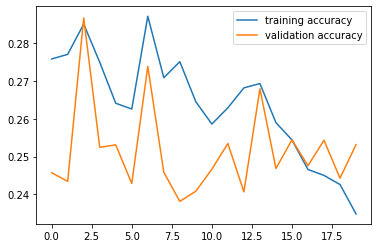

In [ ]:
### --- Plotting the model of task 6
plt.plot(model_Task6.history['loss'], label = 'training accuracy')
plt.plot(model_Task6.history['val_loss'], label = 'validation accuracy')
plt.legend()
plt.show()

In [ ]:
### --- Evaluating the model of task 6 on the testing set

test_score = model_task6.evaluate(X_test_q3, y_test_q3, verbose = 0)

### --- Printing the results
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Test loss: 8.95422649383545
Test accuracy: 0.1599999964237213


In [ ]:
### --- saving the task 6 model

model_task6.save("model.h5")

